# CK Mapping

## Model Creation

In [2]:
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
import markdown
import re
from IPython.display import display, Markdown

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import re

In [6]:
import matplotlib.pyplot as plt

In [7]:
api_key = "API_KEY"
client = OpenAI(api_key = api_key)

In [8]:
# initial concept input is title and product description
class Concept:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI's refined description
        self.type = "Concept"  # Tracks as a concept

class Knowledge:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI’s deeper reasoning carried forward
        self.type = "Knowledge"  # Tracks as knowledge
        
# 🔹 Graph System for Tracking C-K Transitions 🔹
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.history = []
        self.transition_history = []

    def add_node(self, name, nodetype, description):
        """Generalized method to add either a Concept or Knowledge to the graph."""
        self.graph.add_node(name, type=nodetype, description=description)

    def add_edge(self, parent, child, transformation):
        """Tracks transitions between concepts and knowledge dynamically."""
        self.graph.add_edge(parent.name, child.name, type=transformation)
        self.history.append((parent.name, child.name, transformation))
        self.transition_history.append(transformation)
        print(f"🔄 {transformation}: {parent.name} → {child.name}")

    def visualize_graph(self):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(self.graph)
        labels = nx.get_edge_attributes(self.graph, "type")

        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3500, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()
        

In [9]:
def get_embedding(text, model = "text-embedding-3-small"):
    response = client.embeddings.create(input=text, model=model, dimensions = 512)
    return response.data[0].embedding

In [10]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

In [11]:
def extract_knowledge_details(text):
    title_match = re.search(r'Knowledge Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Knowledge Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [12]:
def extract_concept_details(text):
    title_match = re.search(r'Concept Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Concept Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [13]:
def penalize_repetition_check(concept_database, number_concept):
    sys_prompt = f"""
    You are a C-K Theory expert. In the input, I provided {number_concept} sets of consecutive C-->C operations where each group of concepts are separated by a comma and contain a concept title and a concept description. In a C-->C operation the concepts are expanding by partitioning and exploring new attributes. Do these expanding concepts still hold significant ambiguity or unexplored potential that cannot yet be resolved or validated? Note, that this path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on determining whether there exists truly novel propositions that can transform or extend the knowledge space? Are the iterations becoming repetitive in its idea and content? These are questions you ask yourself while determining whether to say Yes or No on whether or not we should continue doing C-->C operation.
    """
    prompt = ', '.join(concept_database)
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5
        )
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Respond with a "yes" or "no". Do not include periods in your response.
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [14]:
def givenC_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f"""
    C-K THEORY EXPERT DECISION SYSTEM 
    Your role is to evaluate the current concept/knowledge and determine the optimal transformation.
    The topic you are working on is to {topic}
   
    ---
    Current Concept: {title} 
    Description: {description}
    Past Transformations: {past_transformations}
    Existing Knowledge Base: {past_knowledge}
    Context: 
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step represents the design process.
    Note, the definition of design process in this regard is the process by which a concept generates other concepts or is transformed into knowledge. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.

  🔍 Your Goal:
    1️⃣ Evaluate whether to go from concept to concept or concept to knowledge. Ensure your decision represents the design process based on the information of the current concept, description, past transformations, and existing knowledge base.
    - C-->C (Concept Expansion): Use this if the concept still holds significant ambiguity or unexplored potential that cannot yet be resolved or validated with the existing knowledge base. This path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on exploring whether there exists truly novel propositions that can transform or extend the knowledge space.
    - C-->K (Concept to Knowledge): Choose this path when the concept has been sufficiently refined and aligns with the existing knowledge base, allowing it to be tested, validated, or implemented. This transition is appropriate when the concept can be logically integrated into the knowledge space, resolving its ambiguity and proving its feasibility or truthfulness within the current understanding. Note, the integration of new knowledge is not just about validation but also about whether the concept can enrich the knowledge space. If it meets some of these criteria, it is time to go to K.
Determine whether we should go to concept or knowledge. 
 
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from concept to concept or concept to knowledge. Respond with either 'Concept' for C-->C or 'Knowledge' for C-->K 
    """
    
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [15]:
def givenK_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f""""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
 ---
    Current Knowledge: {title}
    Description: {description}
    Past Transformations: {past_transformations}
     Context:
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation.
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.

Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    🔍 Your Goal:
    1️⃣ Evaluate Possible Transformations Dynamically:
    - K→C (Concept Expansion): Used when existing knowledge suggests new concepts or when you suspect new insights from K can lead to the generation of new concepts.
    - K→K (Concept to Knowledge): Used to expand the knowledge space by adding new validated propositions or insights. This is typically performed when new information is created usually from things like C→K.

Use the Current Knowledge Space for reference: [{past_knowledge}]
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from knowledge to concept or knowledge to knowledge. Respond with either 'Concept' for K-->C or 'Knowledge' for K-->K"
    """
    
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content
    

In [16]:
def scraped_data_to_string(df_scraped_data):
    """
    This takes in a scraped data from the dataframe and turn it into a string of knowledge bases for LLM inputs
    """
    formatted_strings = []
    for index, row in df_scraped_data.iterrows():
        # format the string for each row
        formatted_string = f"Title: {row['Title']} Description: {row['Description']}"
        # append the formatted string to the list
        formatted_strings.append(formatted_string)

    result = ''.join(formatted_strings)
    return result

In [17]:
def determine_operation_concept2(concept_title, concept_description, df_knowledge, transition_history, topic, force_k, concept_space):
    past_concepts = ', '.join(transition_history)
    past_transitions = ', '.join(transition_history)
    past_knowledge = scraped_data_to_string(df_knowledge)
    determine_operation_direc = givenC_determine_c_or_k(concept_title, concept_description, past_transitions, past_knowledge, topic)
    if force_k is True:
        transition_choice = 'C-->K' 
        prompt_c_to_k = f"""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI Specializing in Design Innovation using C-K  Theory.
Your role is to evaluate the current concept.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
Existing Concept Space *this is just for reference as to what has already been done* (each concepts are separated by a comma): {past_concepts}
Existing Knowledge Space: {past_knowledge}
Description: {concept_description}
Past Transitions: {past_transitions}
Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
            """

        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
    else: 
        if determine_operation_direc.lower() == "concept":
            transition_choice = 'C-->C'
            prompt_c_to_c = f"""
        C-K THEORY EXPERT DECISION SYSTEM
        You are an AI Specializing in Design Innovation using C-K  Theory.
        Your role is to evaluate the current concept.
        The topic you are working on is to {topic}
        You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
        Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
        Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
        Existing Concept Space *this is just for reference as to what has already been done, so do not copy the concepts* (each concepts are separated by a comma): {past_concepts}
        Existing Knowledge Space: {past_knowledge}
        Current Concept: {concept_title} 
        Description: {concept_description}  
        Past Transitions: {past_transitions}
        Your goal is to identify specific areas of the concept that remains unexplored or ambiguous. Utilize the existing knowledge base as a reference to guide your exploration. The goal is to get truly novel propositions and attributes that can enhance the concept space and lead to new discovery in the knowledge space.
        Provide a new concept title and description.
          """


            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content

        elif determine_operation_direc.lower() == "knowledge":
            transition_choice = 'C-->K' 
            prompt_c_to_k = f"""
        C-K THEORY EXPERT DECISION SYSTEM
    You are an AI Specializing in Design Innovation using C-K  Theory.
    Your role is to evaluate the current concept.
    The topic you are working on is to {topic}
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    Existing Concept Space *this is just for reference as to what has already been done* (each concepts are separated by a comma): {past_concepts}
    Existing Knowledge Space: {past_knowledge}
    Current Concept: {concept_title}
    Description: {concept_description}
    Past Transitions: {past_transitions}
    Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
                """

            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
            new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
            df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
            # compute embeddings only for new row
#             new_index = df_knowledge.index[-1]
#             df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#             df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)

        else:
            error_message = f"Error: The operation direction '{determine_operation_direc}' is not recognized. It must be either 'concept' or 'knowledge'."
            raise ValueError(error_message)
    return final_title, final_desc, transition_choice, df_knowledge

In [18]:
def determine_operation_knowledge(knowledge_title, knowledge_description, df_knowledge, transition_history, topic, concept_space):
    """Input: concept_title (text), concept_description (text), dataframe knowledge space (pandas df), past_transitions
    Output: chosen operation and new concept/knowledge title + description"""
    past_concepts = ', '.join(concept_space)
    past_transitions = ', '.join(transition_history)
    transition_choice = None
    past_knowledge = scraped_data_to_string(df_knowledge)
    K_or_C = givenK_determine_c_or_k(knowledge_title, knowledge_description, past_transitions, past_knowledge, topic)
    
    if K_or_C.lower() == "knowledge":
        transition_choice = "K-->K"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Existing Concept Space *this is just for reference* (each concepts are separated by a comma): {past_concepts}
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to expand the knowledge space by adding new validated propositions or insights. Utilize the concept space for reference.
 And use the current Knowledge Space for reference: [{past_knowledge}]
        """
        
        response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
        
    elif K_or_C.lower() == "concept":
        transition_choice = "K-->C"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Existing Concept Space *this is just for reference* (each concepts are separated by a comma): {past_concepts}
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to to use existing knowledge to suggest new concepts. Avoid repeating concepts in the concept space. Instead, add new propositions and novelty to the concept space.
 Use the current Knowledge Space for reference: [{past_knowledge}]
        """
        
        response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        
    else: 
        error_message = f"Error: The operation direction '{K_or_C}' is not recognized. It must be either 'concept' or 'knowledge'."
        raise ValueError(error_message)
        
    
    return final_title, final_desc, transition_choice, df_knowledge
 

In [19]:
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_node(self, name, type, description):
        self.graph.add_node(name, type=type, description=description)

    def add_edge(self, parent_name, child_name, transition_choice):
        self.graph.add_edge(parent_name, child_name, transition=transition_choice)


In [20]:
system = ConceptKnowledgeSystem()

In [21]:
df_know_embed = pd.read_csv('data/amazon links/hammering_nail_req.csv')

In [22]:
current_type = "concept"
current_desc = "A nail holder avoiding to hurt one's hand while hammering"
current_title = "Avanti nail holder"
past_transitions = []
# df_know_embed = pd.read_pickle('data/amazon links/amazon_nail_embedding.pkl')
topic = "design a creative nail holder for when a person is hammering a nail."
list_concepts = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
concept_space = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
num_C_repeat = 0
force_k = False
similarity_lists = []
avg_iteration_sim = []

In [23]:
for i in range(50):
    if current_type == "concept":
        # Determine the next operation from the concept
        new_title, new_desc, transition_choice, new_df = determine_operation_concept2(current_title, current_desc, df_know_embed, past_transitions, topic, force_k, concept_space)
        
    elif current_type == "knowledge": 
        new_title, new_desc, transition_choice, new_df = determine_operation_knowledge(current_title, current_desc, df_know_embed, past_transitions, topic, concept_space)
    
    else:
        print("there was an issue in identifying current type")
        pass
    
    system.add_node(current_title, current_type, current_desc)
    if transition_choice in ["C-->C", "K-->C"]:
        new_type = "concept"
    elif transition_choice in ["C-->K", "K-->K"]:
        new_type = "knowledge"
    else:
        print("there was an issue in getting the new type")
        pass
    print(f"Iteration {i+1}:")
    print(f"  Current Title: {current_title}")
    print(f"  Current Description: {current_desc}")
    print(f"  Transition: {transition_choice}")
    print(f"  New Title: {new_title}")
    print(f"  New Description: {new_desc}")
    print(f"  Past Transitions: {past_transitions}")
    print("-" * 40)
    
    system.add_edge(current_title, new_title, transition_choice)
    past_transitions.append(transition_choice)
    concept_space.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
    embedded_concept_space = [get_embedding(concept) for concept in concept_space]
    
    if len(embedded_concept_space) < 2:
        pass
    else:
        avg_sims = []
        iteration_similarities = []
        count = 0
        total_similarity = 0
        for i in range(len(embedded_concept_space)):
            for j in range(i+1, len(embedded_concept_space)):
                similarity = cosine_similarity(embedded_concept_space[i], embedded_concept_space[j])
                iteration_similarities.append(similarity)
            if iteration_similarities:
                # note this is the average similarity for all individual i iterations
                average_sim = sum(iteration_similarities)/len(iteration_similarities)
                avg_sims.append(average_sim)
        similarity_lists.append(iteration_similarities)
        avg_iteration_sim.append(avg_sims)
    
#     if transition_choice in ["C-->C"]:
#         list_concepts.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
#         num_C_repeat += 1
#         if num_C_repeat >= 5:
#             decision_on_k = penalize_repetition_check(list_concepts, num_C_repeat)
#             if decision_on_k.lower() == 'yes':
#                 force_k = True
#                 print("This is the decision from the repetition checker", decision_on_k)
#             else:
#                 print("This is the decision from the repetition checker", decision_on_k)
#                 force_k = False
#     else:
#         list_concepts = []
#         num_C_repeat = 0
#         force_k = False
    
    df_know_embed = new_df
    current_title, current_desc, current_type = new_title, new_desc, new_type
    

Iteration 1:
  Current Title: Avanti nail holder
  Current Description: A nail holder avoiding to hurt one's hand while hammering
  Transition: C-->C
  New Title: [Magnetic Alignment Nail Holder]
  New Description: [The Magnetic Alignment Nail Holder introduces the concept of integrating magnetic technology to enhance nail holding and guidance during hammering. This concept explores the possibilities of using strategically placed magnets to secure nails in position, enhancing the control and precision of nail placement. The primary feature is a built-in magnetic alignment system that aligns the nail perpendicularly to the surface, ensuring optimal hammering angle and reducing the risk of misalignment. The concept proposes a mechanism allowing users to adjust the magnetic strength based on the size and weight of the nail, providing customized holding power that accommodates various nail types and sizes. Implementing a magnetic guide feature helps in automatically aligning the nail corre

Iteration 5:
  Current Title: [Holo-Interactive Nail Holder]
  Current Description: [The Holo-Interactive Nail Holder introduces a pioneering approach to carpentry tools by incorporating holographic technology and interactive user engagement, creating a fully immersive experience for both novice and expert users. This concept aims to expand the dimensions of usability, learning, and safety by exploring the untapped potential of augmented reality and network connectivity. Key features include holographic projection guidance that renders step-by-step visual instructions directly onto the work surface, enhancing precision and craftsmanship. The network-enabled community sharing feature connects users to a cloud-based platform for sharing projects and accessing tutorials, fostering a digital carpentry community. Advanced haptic feedback mechanisms provide tactile responses for immediate corrective action, while voice-activated controls allow hands-free operation. The holder is constructed 

Iteration 8:
  Current Title: [Multi-Dimensional Acoustic Nail Holder]
  Current Description: [The Multi-Dimensional Acoustic Nail Holder represents a groundbreaking advancement in nail holder design, introducing acoustic dynamics and multidimensional interaction to the conventional hammering process. This concept harnesses innovative acoustic technology to address potential areas of ambiguity and explore unimaginable horizons for precision, efficiency, and safety in carpentry tools. Key features include acoustic grip feedback with microscale acoustic sensors providing real-time auditory feedback for optimal holding force, vibrational energy modulation using vibrational nanomaterials to absorb and dissipate hammer impact vibrations, and time-projection mapping with embedded holographic projectors for real-time nail path visualization. The holder also features thermo-acoustic adaptability, modifying its structure through thermo-acoustic interactions for optimal grip in varying temperatu

Iteration 11:
  Current Title: [Quantum-Haptic Hybrid Nail Holder]
  Current Description: [The Quantum-Haptic Hybrid Nail Holder is a transformative innovation that integrates cutting-edge quantum mechanics with advanced haptic feedback systems to elevate precision and control in nail holding and hammering. Key features include Quantum Resonance Stabilization, which utilizes quantum coherence to stabilize the nail holder and reduce microscopic shifts during hammering, ensuring maximum control and precision. Haptic Feedback Assurance provides real-time tactile feedback, simulating subatomic interactions during nail entry, promoting efficient and safe usage. Nano-Material Coating incorporates materials structured at the nanoscale for enhanced durability and resistance against friction and wear. The Physio-Quantum Mapping System offers a visual display mapping of the user’s grip and pressure distribution in relation to quantum forces, guiding optimal handle ergonomics for customized comfo

Iteration 14:
  Current Title: [Bio-Adaptive Intelligent Nail Holder]
  Current Description: [The Bio-Adaptive Intelligent Nail Holder pioneers a novel approach by incorporating biomechanical and biometric adaptation into the nail-holding process, advancing both safety and efficiency. This innovative tool utilizes biofeedback sensors that interact with the user’s grip and posture, dynamically adjusting the nail holder’s grip pressure and orientation for optimal ergonomic support. It incorporates sensors that monitor user hand positioning and grip force, automatically adjusting its geometry to ensure optimal alignment with the user's natural biomechanics. Real-time feedback on grip pressure is provided through gentle vibrations, encouraging safe and effective hammering techniques. The holder integrates fingerprint recognition and user profiling to adjust settings according to individual user preferences, such as preferred grip tightness and user-specific nail types. Personalized user da

Iteration 17:
  Current Title: [Multi-Sensory Augmentation Nail Holder]
  Current Description: [The Multi-Sensory Augmentation Nail Holder reimagines the nail-holding experience by integrating sensory enhancement technologies to improve user interaction and task precision. It features a Vision Augmentation Display that uses augmented reality (AR) to overlay stability, angle guides, and hammering trajectory onto the nail and surface through AR glasses or a mobile app, enhancing precision and reducing errors. The Tactile Sensory Amplification system employs micro-vibration technology to provide tactile feedback on nail angle and depth, offering sensory confirmation even with gloves. An Auditory Guidance Feedback system delivers real-time feedback on hammering technique and stability through audio cues, customizable for different skill levels. Environmental Sensors Integration detects conditions like humidity, temperature, and material density, adjusting grip and pressure sensitivity for 

Iteration 20:
  Current Title: [Cognitive Adaptive Nail Holder]
  Current Description: [The Cognitive Adaptive Nail Holder introduces an advanced integration of cognitive technology and ergonomic design, propelling the nail holder into a new realm of intuitive functionality and user-centric adaptability. This innovative concept capitalizes on an unexplored synergy between advanced cognitive systems and physical design, extending the boundaries of both user interaction and tool intelligence. It features a Cognitive Integration Framework employing neural network-based algorithms capable of learning and predicting user preferences and behaviors over time, ensuring a personalized experience that optimizes grip, pressure, and feedback. The Neuromorphic Feedback System provides enhanced sensory feedback, including subtle auditory and visual cues based on real-time analysis of user action and environmental conditions, encouraging precision and safety. The Self-Optimizing Grasp Mechanism utili

Iteration 23:
  Current Title: [Innovative Nail Holder Concepts: Haptic Feedback, Eco-Sensing, AI Learning, Interactive Projection, and Biodegradable Modularity]
  Current Description: [The Haptic Precision Nail Holder introduces an advanced haptic feedback system that provides real-time tactile feedback on grip pressure, angle, and alignment. This system uses precise vibrational cues to guide the user's hand movements, enhancing precision and reducing mistakes. It includes adaptive technology that learns from the user's hammering style, optimizing feedback for individual preferences over time. Constructed with a flexible, shock-absorbent material, it offers a lightweight, durable design suitable for various environments. The Eco-Sensing Nail Holder focuses on sustainability and environmental interaction, featuring embedded eco-sensors that monitor ecological conditions like temperature and humidity. These sensors adjust the holder's material properties dynamically to maintain performa

Iteration 25:
  Current Title: [Bio-Adaptive Nail Holder]
  Current Description: [The "Bio-Adaptive Nail Holder" leverages biomimicry and biological principles to create a nail holder that adapts to the natural mechanics of human movement and environmental conditions. Key features include: Biomimetic Grip Adaptation, inspired by plant tendrils and animal limbs, ensures the nail holder adapts to the user’s hand size and grip strength, offering superior comfort and stability. Self-Healing Material Technology, drawing inspiration from biological tissue healing, allows the nail holder to self-repair damages, extending its lifespan. Environmental Adaptive Surfaces use materials that alter surface texture in response to humidity or temperature, ensuring stable grip in diverse environments. Biosensing Feedback Mechanism, equipped with biosensors, analyzes physiological data to provide real-time feedback, improving accuracy and stability. Eco-Regenerative Energy Use integrates biophotovoltaic 

Iteration 28:
  Current Title: [Quantum-Bio-Haptic Evolution of Nail Holders]
  Current Description: [The "Quantum-Bio-Haptic Evolution of Nail Holders" proposes a revolutionary approach to tool design by merging quantum computing, biological inspiration, and haptic feedback technologies. This concept advances the existing design by incorporating unexplored dimensions, such as user-environment interaction via tactile feedback mechanisms and biotic symmetry in structural design, thus enhancing functionality and user experience. Key innovations include a Quantum-Driven Adaptive Haptic Feedback System that employs quantum algorithms to modulate haptic feedback in real-time, providing tactile cues about optimal grip strength, nail position, and hammer trajectory. Bio-Symbiotic Design Structures inspired by biological systems mimic natural forms and patterns to achieve optimal weight distribution and structural resilience. An Augmented Reality Haptic Interface integrates AR with haptic tech

Iteration 31:
  Current Title: [Quantum-Integrated Modular Nail Assist System]
  Current Description: [The "Quantum-Integrated Modular Nail Assist System" introduces a revolutionary approach to nail holder design by incorporating modular components that enhance user interaction, customization, and efficiency. Key features include Modular Quantum Components (MQC) for customizable functionality, Quantum Dot Infused Visual Feedback Modules for real-time safety and precision cues, and Bio-Synthetic Nano-Sensor Modules (BS-NSM) for adaptive grip and fatigue reduction. The Dynamic Multi-Environment Adaptation (DMEA) ensures seamless operation across various conditions, while Self-Healing Modular Integration extends durability through automatic repair of minor damages. The User-Centric Sustainability Analytics Hub provides insights into environmental impact, promoting sustainable practices. The Custom Comfort Layering System (CCLS) allows personalized ergonomic adjustments, and the Maintenanc

Iteration 34:
  Current Title: [Quantum-Interface Nail Holding System (QINHS)]
  Current Description: [The "Quantum-Interface Nail Holding System" (QINHS) embarks on an avant-garde journey in nail-holding technology by integrating principles of quantum mechanics with tangible user interactions. This concept transcends traditional mechanical and neuro-responsive paradigms, delving into quantum-enhanced tool functionality and user engagement. Quantum Entanglement Adjustment (QEA) employs quantum entanglement techniques for instantaneous feedback and precision adjustments, ensuring atomic-level alignment and stability of the nail concerning the hammer. Micro-Vibration Resonance Control (MVRC) utilizes quantum vibrations to control micro-vibrations transmitted through the nail holder upon impact, reducing physical strain and aiding accuracy. Quantum Energy Stabilization Harness (QESH) captures ambient quantum energy fluctuations, converting them into stabilized power for the tool, minimizi

Iteration 36:
  Current Title: [Quantum-Enhanced Adaptive Nail Holder (QEANH)]
  Current Description: [The "Quantum-Enhanced Adaptive Nail Holder" (QEANH) is an innovative advancement in nail-holding technology, harnessing quantum mechanics principles to adapt to various user needs and environmental conditions. This concept builds upon the existing "Quantum Feedback-Driven Nail Positioning System" by focusing on adaptability, user customization, and integration with existing carpentry methods. Quantum-Driven Material Morphology (QDMM) utilizes quantum algorithms to dynamically alter the physical properties of the nail holder's material, enabling the holder to adjust its firmness and grip based on the size and type of nail, optimizing stability and security during hammering. Quantum Cognitive Interface (QCI) integrates quantum-aware sensors to perceive and adapt to user cognitive states, such as stress levels and focus, providing seamless adjustments to tool settings, enhancing user com

Iteration 38:
  Current Title: [Quantum-Enhanced User Adaptive Nail Holding System (QUANHS)]
  Current Description: [The "Quantum-Enhanced User Adaptive Nail Holding System" (QUANHS) introduces a breakthrough in tool design by leveraging quantum principles to create a highly personalized and adaptive nail holding experience. Building upon the current Quantum-Based Multi-Dimensional Interface, this concept delves deeper into user-specific interaction by utilizing quantum computing's unparalleled data processing capabilities to tailor tool behavior to user preferences, environmental conditions, and task-specific requirements. Key elements include Quantum Feedback Customization (QFC), which employs quantum algorithms to analyze user motion patterns and tool interaction history, dynamically adjusting feedback loops in real-time to enhance precision and comfort. Environmental Quantum Sensing (EQS) integrates quantum sensors to detect subtle changes in external conditions, adapting holding a

Iteration 41:
  Current Title: [Quantum-Integrated Eco-Smart Nail Holder (QIES-NH)]
  Current Description: [The Quantum-Integrated Eco-Smart Nail Holder (QIES-NH) merges sustainability with quantum-driven innovations, redefining user safety, environmental impact, and tool interaction. Quantum Eco-Material Analysis (QEMA) uses quantum algorithms to evaluate and optimize material selection for reduced ecological impact, ensuring sustainable resources without compromising durability. Quantum-Sensing Eco Feedback (QSEF) integrates environmental sensors with quantum processors to adjust operational parameters based on real-time environmental metrics, maintaining device integrity across varied climates. Quantum-Enhanced Solar Adaptability (QESA) employs miniaturized solar cells with quantum efficiency enhancements for self-sustaining energy, reducing reliance on traditional power sources. Quantum Behavioral Insights (QBI) processes tool usage data to offer insights into environmentally respo

Iteration 44:
  Current Title: [Neural Adaptive Nail Holder (NANH)]
  Current Description: [The Neural Adaptive Nail Holder (NANH) introduces an innovative concept that incorporates neural network integration and adaptive sensor technology, creating a highly intelligent and responsive nail holding system. It aims to revolutionize user interaction by embedding advanced neural learning algorithms alongside existing ergonomic and safety features. The Neural Interaction Core (NIC) is a neural network-based learning system that continuously analyzes and adapts to user behavior for optimized performance, capturing user data on hand placement, grip strength, and nail alignment, and offering tailored feedback and recommendations. Adaptive Sensory Feedback (ASF) utilizes integrated sensors to provide real-time, haptic feedback, enhancing control and precision during hammering and reducing error rates. Cognitive Strain Relief (CSR) combines neural data with ergonomic assessments to automatically

Iteration 47:
  Current Title: [Quantum-Enhanced Augmented Safety Nail Holder: Bridging Innovative Quantum Applications with Practical Tool Design]
  Current Description: [The Quantum-Enhanced Augmented Safety Nail Holder (QEASNH) concept introduces innovative features that align with existing knowledge while proposing new technological integrations. The Quantum Precision Alignment System (QPAS) enhances visibility and precision, though it requires validation of quantum algorithm feasibility in tool manufacturing. The Augmented Quantum Safety Layer (AQSL) addresses safety and visibility through AR, but its integration with quantum safety networks needs further exploration. Quantum Resonance Feedback Enhancement (QRFE) aligns with ergonomic goals, yet applying quantum principles for feedback is speculative. The Zero-Gravity Quantum Balance (ZGQB) proposes ergonomic benefits but requires significant technological advancements. The Quantum Eco-Vision Interface (QEVI) supports sustainabili

Iteration 49:
  Current Title: [Multi-Sensory Intuitive Nail Holder]
  Current Description: [The Multi-Sensory Intuitive Nail Holder concept introduces a holistic and multi-faceted approach by integrating underexplored sensory realms and adaptive technologies that transcend the traditional tool interaction paradigm. It incorporates haptic feedback modulation with tactile feedback mechanisms that simulate nail penetration depth and resistance changes, enhancing intuitive user adjustments. Eco-Adaptive Material Dynamics utilize eco-sensitive materials that respond to environmental conditions, providing adaptive grip and structural support. Anisotropic Resistance Control features a surface pattern that modifies resistance based on force direction, facilitating precise nail driving. Neural Pathway Augmentation engages user neural pathways with auditory cues to enhance task engagement and cognitive recall. Modular Sensory Expansion Units allow customization with varied sensory augmentations

In [30]:
averages = [sum(sublist)/len(sublist) for sublist in avg_iteration_sim]

In [31]:
averages2 = [sum(sublist)/len(sublist) for sublist in similarity_lists]

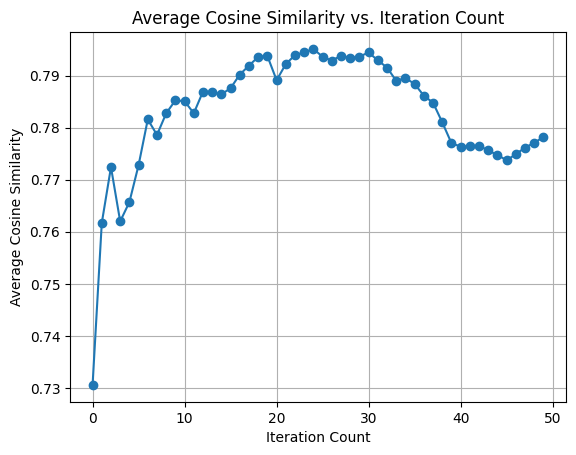

In [32]:
plt.plot(range(len(averages)), averages, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

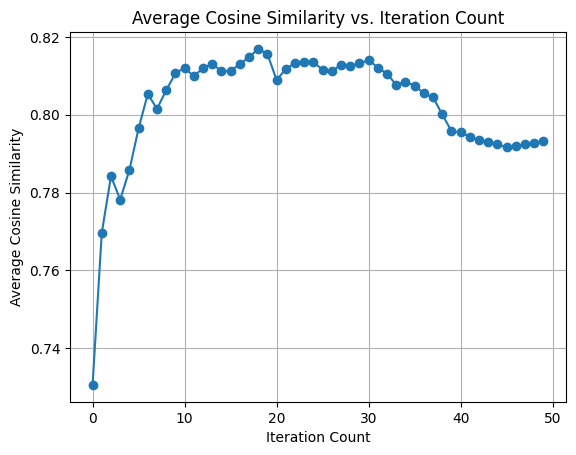

In [33]:
plt.plot(range(len(averages2)), averages2, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

## Saving embeddings

In [24]:
import pickle

In [25]:
df_know_embed.to_csv("know-space_withoutFBloop_ConMemYes-gpt4o.csv")

In [26]:
df_con = pd.DataFrame(concept_space, columns = ['concepts'])

In [27]:
df_con.to_csv("con-space_withoutFBloop_ConMemYes-gpt4o.csv")

In [28]:
with open('avg_iter_sim_withoutFBloop_ConMemYes-gpt4o.pkl', 'wb') as file:
    pickle.dump(avg_iteration_sim, file)

In [29]:
with open('sim_list_withoutFBloop_ConMemYes-gpt4o.pkl', 'wb') as file:
    pickle.dump(similarity_lists, file)

In [34]:
with open('past_transitions_withoutFBloop_ConMemYes-gpt4o.pkl', 'wb') as file:
    pickle.dump(past_transitions, file)

## Calculating Diversity

In [70]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA

In [54]:
embdding_c_space = [get_embedding(concept) for concept in concept_space]

In [71]:
def convexhull(x, n_components):
    pca = PCA(n_components = n_components)
    reduced_data = pca.fit_transform(x)
    explained_ratio = pca.explained_variance_ratio_
    hull = ConvexHull(reduced_data)
    volume = hull.volume
    return volume, explained_ratio

In [72]:
def DPP_diversity(x, lambda0=0):
    # Normalize the rows of x to have unit norm
    x_normalized = x / np.linalg.norm(x, axis=1, keepdims=True)
    
    # Compute the cosine similarity matrix S
    S = np.dot(x_normalized, x_normalized.T)
    
    # Transform cosine similarity values to be non-negative
    S_non_negative = (S + 1.0) / 2.0
    
    # Create a vector of ones with the same length as the number of points in x
    y = np.ones(x.shape[0])
    
    # Compute the outer product of y with itself
    Q = np.outer(y, y)
    
    if lambda0 == 0:
        L = S_non_negative
    else:
        L = S * np.power(Q, lambda0)
    
    try:
        eig_val = np.linalg.eigh(L)[0]
    except np.linalg.LinAlgError:
        eig_val = np.ones_like(y)
    
    loss = np.mean(np.log(np.maximum(eig_val, 1e-7)))
    return loss

In [73]:
def L2_vectorized(X, Y):
    #Vectorize L2 calculation using x^2+y^2-2xy
    X_sq = np.sum(np.square(X), axis=1)
    Y_sq = np.sum(np.square(Y), axis=1)
    sq = np.add(np.expand_dims(X_sq, axis=-1), np.transpose(Y_sq)) - 2*np.matmul(X,np.transpose(Y))
    sq = np.clip(sq, 0.0, 1e12)
    return np.sqrt(sq)

In [74]:
def distance_to_centroid(embeddings):
    distances = []
    for i in range(embeddings.shape[0]):
        pca = PCA(n_components = 20)
        embeddings = pca.fit_transform(embeddings)
        mean = np.mean(embeddings[i])
        dist = np.sqrt(np.sum(np.square(np.subtract(embeddings[i], mean))))
        distances.append(dist)
    return np.mean(np.array(distances))

In [75]:
def calc_distance(X, Y, distance="Euclidean"):
    if distance=="Euclidean":
        return L2_vectorized(X,Y)
    else:
        raise Exception("Unknown distance metric specified")

In [76]:
def gen_gen_distance(embeddings, reduction):
    x = embeddings
    res = calc_distance(x, x, distance="Euclidean")
    
    # This sets the diagonal of the matrix to the maximum of elements across the column dimension
    np.fill_diagonal(res, np.max(res, axis=1))
    
    # Pick the smallest values along the columns
    if reduction == "min":
        scores = np.min(res, axis=1)
    # Pick the average value along the columns
    elif reduction == "ave":
        scores = np.mean(res, axis=1)
    else:
        raise Exception("Unknown reduction method")
    
    return np.mean(scores)

In [77]:
convexhull(embdding_c_space, n_components = 15)

(7.358644468108615e-16,
 array([0.21070075, 0.10325271, 0.05930602, 0.04992644, 0.04669875,
        0.03957802, 0.03313273, 0.03177289, 0.029053  , 0.02650959,
        0.02431804, 0.023713  , 0.02176334, 0.01914987, 0.0173171 ]))

## Visualize Graph

In [ ]:
def visualize_graph(system):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(system.graph)
        labels = nx.get_edge_attributes(system.graph, "transition")

        nx.draw(system.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
        nx.draw_networkx_edge_labels(system.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()